In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-5952eae4-a213-86ea-6e25-0633d278de83)


In [10]:
import json
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-03-18 14:09:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2021-03-18 14:09:37 (100 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [11]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = np.array(sentences[0:training_size])
testing_sentences = np.array(sentences[training_size:])
training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

In [12]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(training_padded, training_labels, epochs = 10, validation_data = (testing_padded, testing_labels), verbose = 1)

Epoch 1/10
625/625 [==============================] - 70s 61ms/step - loss: 0.5528 - accuracy: 0.6917 - val_loss: 0.3892 - val_accuracy: 0.8229
Epoch 2/10
625/625 [==============================] - 38s 60ms/step - loss: 0.3544 - accuracy: 0.8393 - val_loss: 0.3777 - val_accuracy: 0.8296
Epoch 3/10
625/625 [==============================] - 38s 60ms/step - loss: 0.3265 - accuracy: 0.8545 - val_loss: 0.3735 - val_accuracy: 0.8325
Epoch 4/10
625/625 [==============================] - 37s 60ms/step - loss: 0.3103 - accuracy: 0.8605 - val_loss: 0.3746 - val_accuracy: 0.8322
Epoch 5/10
625/625 [==============================] - 37s 60ms/step - loss: 0.3031 - accuracy: 0.8636 - val_loss: 0.3804 - val_accuracy: 0.8317
Epoch 6/10
625/625 [==============================] - 38s 60ms/step - loss: 0.2861 - accuracy: 0.8737 - val_loss: 0.3806 - val_accuracy: 0.8286
Epoch 7/10
625/625 [==============================] - 37s 60ms/step - loss: 0.2827 - accuracy: 0.8748 - val_loss: 0.3853 - val_accuracy:

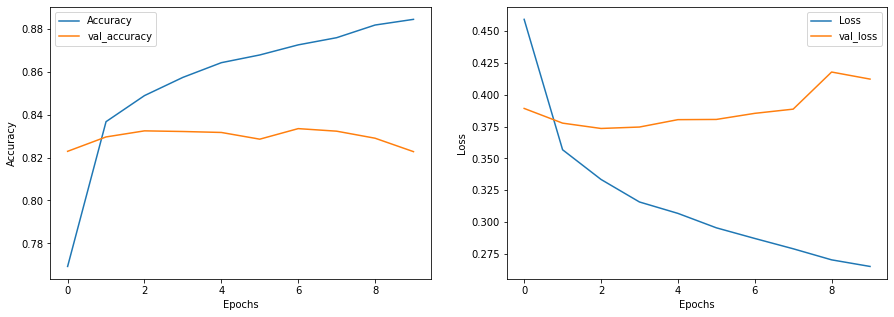

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'val_accuracy'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend(['Loss', 'val_loss'])
plt.show()